In [1]:
import requests
import json
import time
import re
import pprint as pp
import web3
import traceback
import sys
from functools import lru_cache
from web3 import Web3
from web3.auto import w3
from web3.contract import Contract
from web3._utils.events import get_event_data
from web3._utils.abi import exclude_indexed_event_inputs, get_abi_input_names, get_indexed_event_inputs, normalize_event_input_types
from web3.exceptions import MismatchedABI, LogTopicError
from web3.types import ABIEvent
from eth_utils import event_abi_to_log_topic, to_hex
from hexbytes import HexBytes
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql import Window
from graphframes import GraphFrame
from graphframes.examples import Graphs
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

spark

## Get tx and logs raw data via BigQuery connector

In [2]:
spark.conf.set("viewsEnabled","true")
spark.conf.set("materializationDataset","<dataset>")

eth_tx = spark.read.format("bigquery")\
    .option('table', 'bigquery-public-data:crypto_ethereum.transactions') \
    .load()

eth_tx.createOrReplaceTempView('eth_tx')
sql_hash = """
select hash, from_address, to_address, block_timestamp as ts, input from eth_tx
where to_address = lower('0x7be8076f4ea4a4ad08075c2508e481d6c946d12b')
    and DATE(block_timestamp) BETWEEN DATE_ADD(CURRENT_DATE(), -180) AND CURRENT_DATE()
"""

df_tx_0 = spark.sql(sql_hash)
df_tx = df_tx_0.withColumn("date",to_date("ts")).drop('ts')
df_tx.show(10)

# df_tx.groupBy('date').count().show()

+--------------------+--------------------+--------------------+--------------------+----------+
|                hash|        from_address|          to_address|               input|      date|
+--------------------+--------------------+--------------------+--------------------+----------+
|0x4080290efb023bb...|0xd52ee50f173fe2b...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-05|
|0xa6f18cdd60b9bb6...|0x6f14c20d16c4e15...|0x7be8076f4ea4a4a...|0xa8a41c700000000...|2022-01-05|
|0xc831022fc5b7bd4...|0x58aacf5e92acf4d...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-05|
|0x43cc962269c4d86...|0xdec0de987db64ad...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-05|
|0xaa5e6f7b17c1991...|0x13cbb2dcbe4d39d...|0x7be8076f4ea4a4a...|0xa8a41c700000000...|2022-01-05|
|0x14fbb108aa72e17...|0x389dc720310d618...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-05|
|0xeba8b74f9d64c02...|0x67453d1cc8d3df5...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-05|
|0x6ee6207e8b9cdc3...|0x82c573

In [3]:
eth_logs = spark.read.format("bigquery")\
    .option('table', 'bigquery-public-data:crypto_ethereum.logs') \
    .load()
eth_logs.createOrReplaceTempView('eth_logs')

sql_logs = """
SELECT transaction_hash, address as log_address, data, topics, block_timestamp as ts FROM eth_logs 
WHERE address = lower('0x7be8076f4ea4a4ad08075c2508e481d6c946d12b') 
    and DATE(block_timestamp) BETWEEN DATE_ADD(CURRENT_DATE(), -180) AND CURRENT_DATE()
"""

df_logs_0 = spark.sql(sql_logs)
df_logs = df_logs_0.withColumn("log_date",to_date("ts")).drop('ts')
df_logs.show(10)

# df_logs.groupBy('date').count().show()

+--------------------+--------------------+--------------------+--------------------+----------+
|    transaction_hash|         log_address|                data|              topics|  log_date|
+--------------------+--------------------+--------------------+--------------------+----------+
|0x1d4875069a4f7c8...|0x7be8076f4ea4a4a...|0x000000000000000...|[0xc4109843e0b7d5...|2021-12-02|
|0xcf4b3228eea5be8...|0x7be8076f4ea4a4a...|0x000000000000000...|[0xc4109843e0b7d5...|2021-12-02|
|0xdd27daccb5ff854...|0x7be8076f4ea4a4a...|0x000000000000000...|[0xc4109843e0b7d5...|2021-12-02|
|0x58cb624a20d7be7...|0x7be8076f4ea4a4a...|0x000000000000000...|[0xc4109843e0b7d5...|2021-12-02|
|0x0487cd6c6aafe33...|0x7be8076f4ea4a4a...|0x000000000000000...|[0xc4109843e0b7d5...|2021-12-02|
|0xc29a5a7a1181449...|0x7be8076f4ea4a4a...|0x000000000000000...|[0xc4109843e0b7d5...|2021-12-02|
|0xf50465fb0c651e8...|0x7be8076f4ea4a4a...|0x000000000000000...|[0xc4109843e0b7d5...|2021-12-02|
|0x89ddea890376988...|0x7be807

## Join tx and logs to get order input data and topics

In [4]:
df_join = df_tx.join(df_logs, df_tx.hash == df_logs.transaction_hash, 'inner')
df_join = df_join.withColumn("combined", F.to_json(F.struct("data", "topics")))
# df_join = df_join.groupby("hash").agg(F.collect_list("combined").alias("combined_list"))
# df_join = df_join.withColumn("combined_list", F.collect_list('combined').over(Window.partitionBy("hash")))
# use window function

cols = ['hash', 'from_address', 'to_address', 'log_address', 'input', 'data', 'topics', 'date' ]
df_join = df_join.select(cols)
# df_join = df_join.select(cols).distinct()
df_join.printSchema()
# rows = df_join.select('transaction_hash', 'combined').take(2)
df_join.show(10)

root
 |-- hash: string (nullable = false)
 |-- from_address: string (nullable = false)
 |-- to_address: string (nullable = true)
 |-- log_address: string (nullable = true)
 |-- input: string (nullable = true)
 |-- data: string (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: date (nullable = false)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                hash|        from_address|          to_address|         log_address|               input|                data|              topics|      date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|0x000064ffbca7f32...|0x4808c6dd4047dd1...|0x7be8076f4ea4a4a...|0x7be8076f4ea4a4a...|0xab834bab0000000...|0x000000000000000...|[0xc4109843e0b7d5...|2021-1

### ** In general you have to join aggregated results with the original table. Spark SQL follows the same pre-SQL:1999 convention as most of the major databases (PostgreSQL, Oracle, MS SQL Server) which doesn't allow additional columns in aggregation queries.



## Decode single transaction

In [7]:

def decode_tuple(t, target_field):
    output = dict()
    for i in range(len(t)):
        if isinstance(t[i], (bytes, bytearray)):
            output[target_field[i]['name']] = to_hex(t[i])
        elif isinstance(t[i], (tuple)):
            output[target_field[i]['name']] = decode_tuple(t[i], target_field[i]['components'])
        else:
            output[target_field[i]['name']] = t[i]
    return output


def decode_list_tuple(l, target_field):
    output = l
    for i in range(len(l)):
        output[i] = decode_tuple(l[i], target_field)
    return output


def decode_list(l):
    output = l
    for i in range(len(l)):
        if isinstance(l[i], (bytes, bytearray)):
            output[i] = to_hex(l[i])
        else:
            output[i] = l[i]
    return output


def convert_to_hex(arg, target_schema):
    output = dict()
    for k in arg:
        if isinstance(arg[k], (bytes, bytearray)):
            output[k] = to_hex(arg[k])
        elif isinstance(arg[k], (list)) and len(arg[k]) > 0:
            target = [a for a in target_schema if 'name' in a and a['name'] == k][0]
            if target['type'] == 'tuple[]':
                target_field = target['components']
                output[k] = decode_list_tuple(arg[k], target_field)
            else:
                output[k] = decode_list(arg[k])
        elif isinstance(arg[k], (tuple)):
            target_field = [a['components'] for a in target_schema if 'name' in a and a['name'] == k][0]
            output[k] = decode_tuple(arg[k], target_field)
        else:
            output[k] = arg[k]
    return output

# @lru_cache(maxsize=None)
def _get_contract(address, abi):
    """
    This helps speed up execution of decoding across a large dataset by caching the contract object
    It assumes that we are decoding a small set, on the order of thousands, of target smart contracts
    """
    if isinstance(abi, (str)):
        abi = json.loads(abi)

    contract = w3.eth.contract(address=Web3.toChecksumAddress(address), abi=abi)
    return (contract, abi)

@udf
def decode_tx(address, input_data, abi):
    if abi is not None:
        try:
            (contract, abi) = _get_contract(address, abi)
            func_obj, func_params = contract.decode_function_input(input_data)
            target_schema = [a['inputs'] for a in abi if 'name' in a and a['name'] == func_obj.fn_name][0]
            decoded_func_params = convert_to_hex(func_params, target_schema)
            return func_obj.fn_name # json.dumps(decoded_func_params), json.dumps(target_schema))
        except:
            e = sys.exc_info()[0]
            return ('decode error', repr(e), None)
    else:
        return ('no matching abi', None, None)


## Decode single log

In [8]:
from web3._utils.events import get_event_data

# @lru_cache(maxsize=None)
def _get_topic2abi(abi):
    if isinstance(abi, (str)):
        abi = json.loads(abi)

    event_abi = [a for a in abi if a["type"] == "event"]
    topic2abi = {event_abi_to_log_topic(_): _ for _ in event_abi}
    return topic2abi


# @lru_cache(maxsize=None)
def _get_hex_topic(t):
    hex_t = HexBytes(t)
    return hex_t


def decode_log(data, topics, abi):
    if abi is not None:
        try:
            topic2abi = _get_topic2abi(abi)

            log = {
                "address": None,  # Web3.toChecksumAddress(address),
                "blockHash": None,  # HexBytes(blockHash),
                "blockNumber": None,
                "data": data,
                "logIndex": None,
                "topics": [_get_hex_topic(_) for _ in topics],
                "transactionHash": None,  # HexBytes(transactionHash),
                "transactionIndex": None,
            }
            event_abi = topic2abi[log["topics"][0]]
            evt_name = event_abi["name"]

            data = get_event_data(w3.codec, event_abi, log)["args"]
            target_schema = event_abi["inputs"]
            decoded_data = convert_to_hex(data, target_schema)

            return (evt_name, json.dumps(decoded_data), json.dumps(target_schema))
        except Exception:
            return ("decode error", traceback.format_exc(), None)

    else:
        return ("no matching abi", None, None)

## Get ABIs for OpenSea marketplace(Wyvern protocol) and selected NFT contracts

In [14]:
TX_HASH = '0x56f2ce34e4b20578742ed8ddc9fcbacaec62d477a530dff7ace8da2fe64b1208'
OPENSEA_CONTRACT_ADDR = "0x7be8076f4ea4a4ad08075c2508e481d6c946d12b"
BORED_APE_ADDR = "0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D".lower()
name_list = [
    ('0x8a90CAb2b38dba80c64b7734e58Ee1dB38B8992e', 'Doodles'),
    ('0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB', 'CyptoPunks'),
    ('0x60E4d786628Fea6478F785A6d7e704777c86a7c6', 'MutantApe'),
    ('0x50f5474724e0Ee42D9a4e711ccFB275809Fd6d4a', 'Sandbox'),
    ('0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D', 'BoredApe'),
]
name_mappings = dict()
for t in name_list:
    name_mappings[t[0].lower()] = t[1]
    

def fetch_abi(contract_addr):
    ABI_ENDPOINT = 'https://api.etherscan.io/api?module=contract&action=getabi&address='
    response = requests.get('%s%s'%(ABI_ENDPOINT, contract_addr))
    response_json = response.json()
    abi_json = json.loads(response_json['result'])
    return json.dumps(abi_json)

opensea_abi = fetch_abi(OPENSEA_CONTRACT_ADDR)
time.sleep(5)
nft_abi = fetch_abi(BORED_APE_ADDR)

time.sleep(5)

nft_contract_mappings = dict()
for t in name_list:
    nft_contract_mappings[t[0].lower()] = fetch_abi(t[0])
    time.sleep(5)


In [15]:
name_mappings

{'0x8a90cab2b38dba80c64b7734e58ee1db38b8992e': 'Doodles',
 '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb': 'CyptoPunks',
 '0x60e4d786628fea6478f785a6d7e704777c86a7c6': 'MutantApe',
 '0x50f5474724e0ee42d9a4e711ccfb275809fd6d4a': 'Sandbox',
 '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d': 'BoredApe'}

In [16]:
df_join.printSchema()


root
 |-- hash: string (nullable = false)
 |-- from_address: string (nullable = false)
 |-- to_address: string (nullable = true)
 |-- log_address: string (nullable = true)
 |-- input: string (nullable = true)
 |-- data: string (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: date (nullable = false)



## Batch decoding using mapPartitions

In [17]:
def decode(partitionData):
    (contract, abi) = _get_contract(OPENSEA_CONTRACT_ADDR, opensea_abi)
    for row in partitionData:
        if row['input'] is None:
            continue
        try:
            func_obj, func_params = contract.decode_function_input(row['input'])
            target_schema = [a['inputs'] for a in abi if 'name' in a and a['name'] == func_obj.fn_name][0]
            decoded_func_params = convert_to_hex(func_params, target_schema)
            if func_obj.fn_name == 'atomicMatch_':
#                 from_ = decoded_func_params['from']
#                 to_ = decoded_func_params['to']
#                 tokenId = decoded_func_params['tokenId']
                collectible = decoded_func_params['addrs'][4].lower()
                price = int(decoded_func_params['uints'][4]) / 10**18
                if collectible in name_mappings:
                    #decode log
                    data = row['data']
                    topics = row['topics']
                    tx_hash = row['hash']
                    output = decode_log(data, topics, opensea_abi)
                    joutput = json.loads(output[1])
                    maker = joutput['maker']
                    taker = joutput['taker']
                    yield (tx_hash, name_mappings[collectible], maker, taker, price, row['date'])
        except:
            e = sys.exc_info()[0]
            return ('decode error', repr(e), None)


df2 = df_join.rdd.mapPartitions(decode).toDF(['tx_hash', 'collectible', 'maker', 'taker', 'price', 'date'])


In [18]:
from graphframes import *
df_cache = df2.persist()

In [19]:
df_cache.show()

+--------------------+-----------+--------------------+--------------------+---------+----------+
|             tx_hash|collectible|               maker|               taker|    price|      date|
+--------------------+-----------+--------------------+--------------------+---------+----------+
|0x00b8454de263500...|    Sandbox|0x4e26F82AE5760C2...|0x98636A231b89985...|     3.21|2022-01-18|
|0x00d09eb410acff6...|  MutantApe|0x721F6Dbdbf6cAe4...|0xAEF39b6fd3d3fEc...|      4.5|2021-11-12|
|0x0148a6426966398...|    Sandbox|0xc75fC5Aa2270B3c...|0xB43E8A6a604d954...|      8.0|2021-12-26|
|0x01d039b9a4e9196...|  MutantApe|0xb3f8dae49c7F0e9...|0xBD275ED21e220cC...|      6.7|2021-08-29|
|0x01f560c5add9962...|  MutantApe|0x829D111B70845bf...|0x0f494317eB4E532...|     3.49|2021-10-20|
|0x02288021266acd4...|  MutantApe|0xc6d2f1134480c62...|0x34805E6A3796Fb0...|3.5918025|2021-09-13|
|0x034225494e78e9b...|    Doodles|0xAd727E3f0a939e0...|0x690c1E77630aa2c...|      1.0|2021-10-18|
|0x038cc1656efe6a0..

In [ ]:
df_cache.count()

## Graph algorithms(maker/taker as vertices and transfer as edges)

In [ ]:
from pyspark.sql.functions import col

vertices = df_cache.select(col('maker').alias('id')).distinct().union(df_cache.select(col('taker').alias('id')).distinct()).persist()
print(vertices.count())
edges = df_cache.select([col('maker').alias('src'), col('taker').alias('dst')]).persist()
print(edges.count())



In [ ]:
g = GraphFrame(vertices, edges)
print(g)


In [ ]:
g.inDegrees.show()

In [ ]:
g.outDegrees.show()

In [ ]:
sc.setCheckpointDir("/tmp/graphframes-example-connected-components")
result = g.connectedComponents()


In [ ]:
# result.groupby('component').count().show(100)

### Rocha-Thatte algorithm for cycle detection

In [ ]:
from graphframes.lib import *
AM=AggregateMessages
f=F

def find_cycles(sqlContext,sc,vertices,edges,max_iter=5):

    # Cycle detection via message aggregation
    """
    This code is an implementation of the Rocha-Thatte algorithm for large-scale sparce graphs

    Source:
    ==============
    wiki:  https://en.wikipedia.org/wiki/Rocha%E2%80%93Thatte_cycle_detection_algorithm
    paper: https://www.researchgate.net/publication/283642998_Distributed_cycle_detection_in_large-scale_sparse_graphs

    The basic idea:
    ===============
    We propose a general algorithm for detecting cycles in a directed graph G by message passing among its vertices, 
    based on the bulk synchronous message passing abstraction. This is a vertex-centric approach in which the vertices 
    of the graph work together for detecting cycles. The bulk synchronous parallel model consists of a sequence of iterations, 
    in each of which a vertex can receive messages sent by other vertices in the previous iteration, and send messages to other 
    vertices.
    In each pass, each active vertex of G sends a set of sequences of vertices to its out- neighbours as described next. 
    In the first pass, each vertex v sends the message (v) to all its out- neighbours. In subsequent iterations, each active vertex v 
    appends v to each sequence it received in the previous iteration. It then sends all the updated sequences to its out-neighbours. 
    If v has not received any message in the previous iteration, then v deactivates itself. The algorithm terminates when all the 
    vertices have been deactivated.
    For a sequence (v1, v2, . . . , vk) received by vertex v, the appended sequence is not for- warded in two cases: (i) if v = v1, 
    then v has detected a cycle, which is reported (see line 9 of Algorithm 1); (ii) if v = vi for some i ∈ {2, 3, . . . , k}, 
    then v has detected a sequence that contains the cycle (v = vi, vi+1, . . . , vk, vk+1 = v); in this case, 
    the sequence is discarded, since the cycle must have been detected in an earlier iteration (see line 11 of Algorithm 1); 
    to be precise, this cycle must have been detected in iteration k − i + 1. Every cycle (v1, v2, . . . , vk, vk+1 = v1) 
    is detected by all vi,i = 1 to k in the same iteration; it is reported by the vertex min{v1,...,vk} (see line 9 of Algorithm 1).
    The total number of iterations of the algorithm is the number of vertices in the longest path in the graph, plus a few more steps 
    for deactivating the final vertices. During the analysis of the total number of iterations, we ignore the few extra iterations 
    needed for deactivating the final vertices and detecting the end of the computation, since it is O(1).
    
    Pseudocode of the algorithm:
    ============================
    M(v): Message received from vertex v
    N+(v): all dst verties from v

    functionCOMPUTE(M(v)):
        if i=0 then:
            for each w ∈ N+(v) do:
                send (v) to w 
        else if M(v) = ∅ then:
                deactivate v and halt 
        else:
            for each (v1,v2,...,vk) ∈ M(v) do:
                if v1 = v and min{v1,v2,...,vk} = v then:
                    report (v1 = v,v2,...,vk,vk+1 = v)
                else if v not ∈ {v2,...,vk} then:
                    for each w ∈ N+(v) do:
                        send (v1,v2,...,vk,v) to w

    
    Scalablitiy of the algorithm:
    ============================
    the number of iteration depends on the path of the longest cycle
    the scaling it between 
    O(log(n)) up to maxium O(n) where n=number of vertices
    so the number of iterations is less to max linear to the number of vertices, 
    if there are more edges (parallel etc.) it will not affect the the runtime


    for more details please refer to the oringinal publication
    """


#     _logger.warning("+++ find_cycles(): starting cycle search ...")
    
    # create emtpy dataframe to collect all cycles
    cycles = sqlContext.createDataFrame(sc.emptyRDD(),StructType([StructField("cycle",ArrayType(StringType()),True)]))

    # initialize the messege column with own source id 
    init_vertices=(vertices
                   .withColumn("message",f.array(f.col("id")))
                  )
    
    init_edges=(edges
                .where(f.col("src")!=f.col("dst"))
                .select("src","dst")
                )
    
    # create graph object that will be update each iteration
    gx = GraphFrame(init_vertices, init_edges)

    # iterate until max_iter 
    # max iter is used in case that the3 break condition is never reached during this time
    # defaul value=100.000
    for iter_ in range(max_iter):
        
        # message that should be send to destination for aggregation
        msgToDst = AM.src["message"]
        # aggregate all messages that where received into a python set (drops duplicate edges)
        agg = gx.aggregateMessages(
            f.collect_set(AM.msg).alias("aggMess"),
            sendToSrc=None,
            sendToDst=msgToDst)
        
        # BREAK condition: if no more messages are received all cycles where found 
        # and we can quit the loop        
        if(len(agg.take(1))==0):
            #print("THE END: All cycles found in " + str(iter_) + " iterations")
            break
        
        # apply the alorithm logic 
        # filter for cycles that should be reported as found
        # compose new message to be send for next iteration
        # _column name stands for temporary columns that are only used in the algo and then dropped again
        checkVerties=(
            agg
            # flatten the aggregated message from [[2]] to [] in order to have proper 1D arrays
            .withColumn("_flatten1",f.explode(f.col("aggMess")))
            # take first element of the array
            .withColumn("_first_element_agg",f.element_at(f.col("_flatten1"), 1))
            # take minimum element of th array
            .withColumn("_min_agg",f.array_min(f.col("_flatten1")))
            # check if it is a cycle 
            # it is cycle when v1 = v and min{v1,v2,...,vk} = v
            .withColumn("_is_cycle",f.when(
                (f.col("id")==f.col("_first_element_agg")) &
                (f.col("id")==f.col("_min_agg"))
                 ,True)
                .otherwise(False)
            )
            # pick cycle that should be reported=append to cylce list
            .withColumn("_cycle_to_report",f.when(f.col("_is_cycle")==True,f.col("_flatten1")).otherwise(None))
            # sort array to have duplicates the same
            .withColumn("_cycle_to_report",f.sort_array("_cycle_to_report"))
            # create column where first array is removed to check if the current vertices is part of v=(v2,...vk)
            .withColumn("_slice",f.array_except(f.col("_flatten1"), f.array(f.element_at(f.col("_flatten1"), 1)))) 
            # check if vertices is part of the slice and set True/False column
            .withColumn("_is_cycle2",f.lit(f.size(f.array_except(f.array(f.col("id")), f.col("_slice"))) == 0))
           )
        
        #print("checked Vertices")
        #checkVerties.show(truncate=False)
        # append found cycles to result dataframe via union
        cycles=(
            # take existing cycles dataframe
            cycles
            .union(
                # union=append all cyles that are in the current reporting column
                checkVerties
                .where(f.col("_cycle_to_report").isNotNull())
                .select("_cycle_to_report")
                )
        )

        # create list of new messages that will be send in the next iteration to the vertices
        newVertices=(
            checkVerties
            # append current vertex id on position 1
            .withColumn("message",f.concat(
                f.coalesce(f.col("_flatten1"), f.array()),
                f.coalesce(f.array(f.col("id")), f.array())
            ))
            # only send where it is no cycle duplicate
            .where(f.col("_is_cycle2")==False)
            .select("id","message")
        )

        print("vertics to send forward")
        newVertices.sort("id").show(truncate=False)
        
        # cache new vertices using workaround for SPARK-1334
        cachedNewVertices = AM.getCachedDataFrame(newVertices)

        # update graphframe object for next round
        gx = GraphFrame(cachedNewVertices, gx.edges)


    
    # materialize results and get number of found cycles
    #cycles_count=cycles.persist().count()

    _cycle_statistics=(
        cycles
        .withColumn("cycle_length",f.size(f.col("cycle")))
        .agg(f.count(f.col("cycle")),f.max(f.col("cycle_length")),f.min(f.col("cycle_length")))
        ).collect()

    cycle_statistics={"count":_cycle_statistics[0]["count(cycle)"],"max":_cycle_statistics[0]["max(cycle_length)"],"min":_cycle_statistics[0]["min(cycle_length)"]}
    
    end_time =time.time()
#     _logger.warning("+++ find_cycles(): " + str(cycle_statistics["count"]) + " cycles found in " + str(iter_) + " iterations (min length=" + str(cycle_statistics["min"]) +", max length="+ str(cycle_statistics["max"]) +") in " + str(end_time-start_time) + " seconds")
#     _logger.warning("+++ #########################################################################################")


    return cycles, cycle_statistics


In [ ]:
cycles, cycle_statistics = find_cycles(spark,spark.sparkContext,vertices,edges)

In [ ]:
cycles, cycle_statistics

## TODO: Graph neural network modeling
### reference: https://github.com/safe-graph/graph-fraud-detection-papers

## Analyze data with Pandas

In [21]:
import pandas as pd
pdf = df2.toPandas()


NameError: name 'df2' is not defined

In [22]:
pdf.head(10)

NameError: name 'pdf' is not defined

Exception ignored in: <module 'threading' from '/opt/conda/anaconda/lib/python3.7/threading.py'>
Traceback (most recent call last):
  File "/opt/conda/anaconda/lib/python3.7/threading.py", line 1308, in _shutdown
    lock.acquire()
  File "/usr/lib/spark/python/pyspark/context.py", line 270, in signal_handler
    raise KeyboardInterrupt()
KeyboardInterrupt: 
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/opt/conda/anaconda/lib/python3.7/threading.py", line 552, in wait
    signaled = self._cond.wait(timeout)
  File "/opt/conda/anaconda/lib/python3.7/threading.py", line 296, in wait
    waiter.acquire()
  File "/usr/lib/spark/python/pyspark/context.py", line 269, in signal_handler
    self.cancelAllJobs()
  File "/usr/lib/spark/python/pyspark/context.py", line 1039, in cancelAllJobs
    self._jsc.sc().cancelAllJobs()
AttributeError: 'NoneType' object has no attribute 'sc'


In [57]:
des = pdf.groupby('date')['price'].describe()
des


,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2021-08-23,10.0,28.695000,5.579296,22.0000,24.0625,28.745,29.9925,40.00
2021-08-24,15.0,39.465760,9.737879,27.3434,31.9950,36.250,46.4500,62.00
2021-08-25,18.0,39.095739,7.113590,32.3690,35.1675,37.595,39.8250,62.00
2021-08-26,5.0,131.820000,205.876081,35.4100,37.6900,38.000,48.0000,500.00
2021-08-27,5.0,49.733800,13.744148,39.1000,39.5000,42.069,58.0000,70.00
...,...,...,...,...,...,...,...,...
2022-01-13,2.0,117.500000,24.748737,100.0000,108.7500,117.500,126.2500,135.00
2022-01-15,23.0,85.919565,7.379906,78.6900,80.0000,84.000,89.8450,105.00
2022-01-16,4.0,96.000000,13.928388,85.0000,85.0000,92.500,103.5000,114.00


## Outliers in terms of matched price

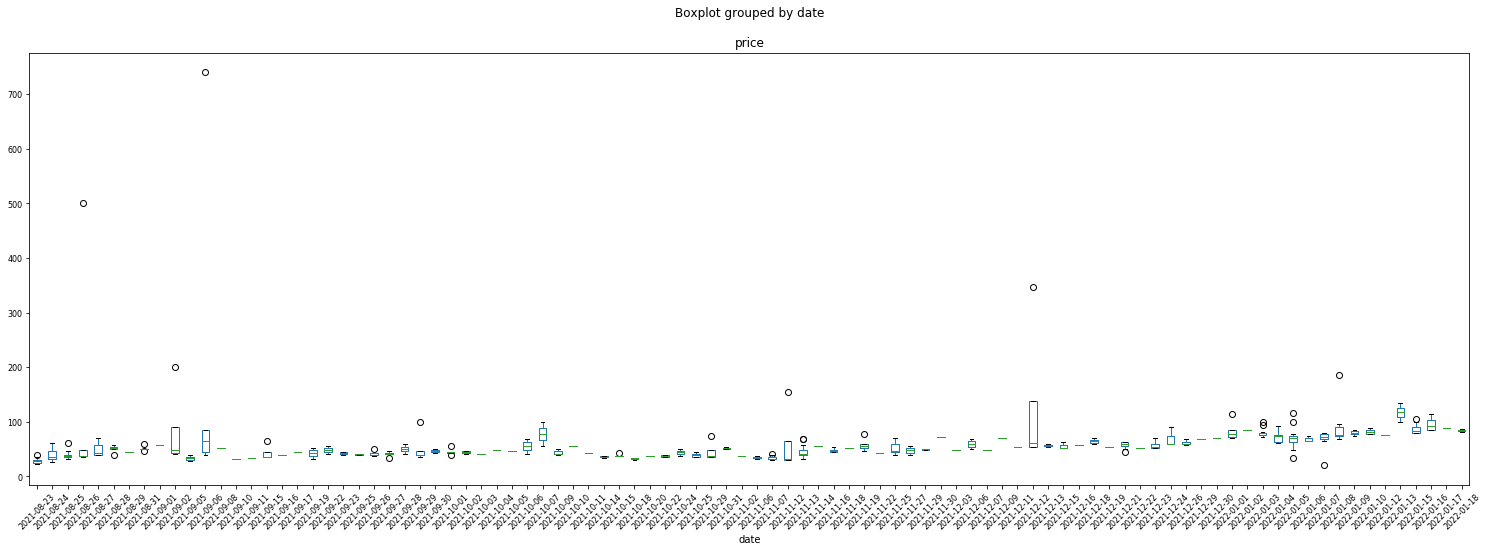

In [59]:
pdf.boxplot(grid=False, rot=45, fontsize=8, column=['price'], by='date', figsize=(25,8))
